# LLM In-Context Learning Demonstration with PubMed Citations Search

### This code demonstrates using Python, the ChatGPT API  and  BioPython libraries to access PubMed to provide 'in-context learnng for ChatGPT. In-context learning provides grounding or ground truth information  for the model to work with and can be used to address the phenomenon of LLM Hallucination (and synchronicity) while still capturing the summarization, reasoning and refinement capabilities of LLM.

### The design and presentation of this code differs from that of it's development. The development started with a prompt, that was refined using both ChatGPT and the ChatGPT playground (https://platform.openai.com/playground). As using the ChatGPT API generates costs based on token use, this is an economical way to conduct prompt engineering and prompt refinement.

### This code demonstation can be divided into 2 sections:

### Section 1:

* Use the Entrez and Medline modules from the BioPython API to conduct a keyword based search of PubMed 
* retreive the most N most recent and N most relevant citations and combines them to form a non-redundant list
* create a formatted string of abstracts to provide an 'in-context learning' string for the LLM

### Section 2:

* Use the ChatGPT API to provide a enigneering prompt for summary, analysis, etc. . . of the 'in-context learning' string.
* output the respons to the prompt.


In [1]:
import openai
import tiktoken
from Bio import Entrez, Medline
from dotenv import dotenv_values

## Part 1: Create the in-context learning 'string' from a PubMed Search

### The BioPython API is more commonly associated with Bioinformatics applications but it has an excellent set of modules to work with PubMed. The capabilities of these modules goes well beyond searching and retrivieng articles from PubMed. They can be explored through these links:

 * https://biopython.org/docs/1.77/api/index.html
 * https://biopython.org/docs/1.77/api/Bio.Entrez.html
 * https://biopython.org/docs/1.77/api/Bio.Medline.html
 
 
 ### The guidelines for usage of Entrez:  
 
 https://biopython-tutorial.readthedocs.io/en/latest/notebooks/09%20-%20Accessing%20NCBIs%20Entrez%20databases.html
 
## Entrez Guidelines 

### Before using Biopython to access the NCBI’s online resources (via Bio.Entrez or some of the other modules), please read the NCBI’s Entrez User Requirements. If the NCBI finds you are abusing their systems, they can and will ban your access!

### To paraphrase:

    * For any series of more than 100 requests, do this at weekends or outside USA peak times. 
    This is up to you to obey.
    * Use the http://eutils.ncbi.nlm.nih.gov address, not the standard NCBI Web address. Biopython uses this web address.
    * Make no more than three requests every seconds (relaxed from at most one request every three seconds in early 
    * This is automatically enforced by Biopython.
    * Use the optional email parameter so the NCBI can contact you if there is a problem. 



In [10]:
# Using the dotenv library allows keeping secret keys secret when sharing code
# This will be used implicity when calling the OpenAI functions in Part of the code.
config = dotenv_values(".env")

In [2]:
# put your email address in here as directed by the NCBI Entrez User Requirements Above
# email could also be stored in the .env file along with the OpenAI API key, see below.
emailAddr = config["GMAIL_ADDR"]

# As there is a token limit, we will artifically limit our search to a maximum of 3 citations
# This is just for proof-of-concept testing
maxResults = 3

# enter the keywords you would like to use for the search here
keywords = 'dystrophic epidermolysis bullosa mouse models gene therapy'

In [3]:
# Pubmed search helper function 1
# Retrieve PMIDs of relevant and recent references with given search terms
# returns combined list of PMIDs with redundant PMIDs removed

def getPMIDs(email,maxR,keywords):
    
    Entrez.email = email
    
    # Get the most relevant citations 
    searchRelevant = Entrez.esearch(db='pubmed', usehistory='y', term=keywords, retmax=maxR, sort='relevance')
    recordsRelevant = Entrez.read(searchRelevant)
    # maintain query state for next search
    
    webenv = recordsRelevant["WebEnv"]
    query_key = recordsRelevant["QueryKey"]

    # get the most recent citations
    searchRecent = Entrez.esearch(db='pubmed', term=keywords, retmax=maxResults, webenv=webenv, query_key=query_key, sort='pub_date')
    recordsRecent = Entrez.read(searchRecent)
    
    searchRelevant.close()
    searchRecent.close()

    # combine recent and relevant citations into one list
    combinedRecords = recordsRelevant['IdList'] + recordsRecent['IdList']
    
    # remove duplicate PMIDs and return the list sorted by PMID
    pmidList = [] 
    [pmidList.append(pmid) for pmid in combinedRecords if pmid not in pmidList]
    pmidList.sort()
    
    return pmidList

# Use the helper function and show the list of PMIDs
myPMIDList = getPMIDs(emailAddr,maxResults,keywords)
print(myPMIDList)

['15335311', '23368767', '27212645', '36212909', '37213713', '37302620']


In [4]:
# Pubmed search helper function 2
#retrieve or fetch the citation by sorted PMID list

def getCitations(pmidList):
    
    fetchHandle = Entrez.efetch(db="pubmed", id=pmidList, rettype="medline", retmode="text")
    records = Medline.parse(fetchHandle)
    records = list(records)
    
    return records

myRecords = getCitations(myPMIDList)

In [5]:
# Context Injection Helper Function
# Here we create the 'Context Injection' string from the abtracts of the retrived records
# You can cut and paste this string into the OpenAI Tokenizer(https://platform.openai.com/tokenizer)
# and get and token cout to see if it will exceed the limit. Alternatively there is the tiktoken
# python library that can be used to estimate the token count:
# https://github.com/openai/tiktoken
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb


def getContextInjection(citationsList):
    # get the abstracts from each citation and concatentate into a string with the #### delimiter
    contextStr = ''
    for record in citationsList:
        contextStr += "####PMID####" + str(record.get("PMID","?")) + "####TITLE####" + str(record.get("TI","?")) + "####ABSTRACT####" + str(record.get("AB","?"))

    return contextStr

abstracts = getContextInjection(myRecords)

# use tiktoken to get token number for the Context String
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
num_tokens = len(encoding.encode(abstracts))

print(num_tokens)
print(abstracts)

1807
####PMID####15335311####TITLE####Gene therapy of epidermolysis bullosa.####ABSTRACT####Easy access to the organ and identification of underlying mutations in epidermolysis bullosa (EB) facilitated the first cutaneous gene therapy experiments in vitro in the mid-1990s. The leading technology was transduction of the respective cDNA carried by a retroviral vector. Using this approach, the genotypic and phenotypic hallmark features of the recessive forms of junctional EB, which are caused by loss of function of the structural proteins laminin-5 or bullous pemphigoid antigen 2/type XVII collagen of the dermo-epidermal basement membrane zone, have been corrected in vitro and in vivo using xenograft mouse models. Recently, this approach has also been shown to be feasible for the large COL7A1 gene (mutated in dystrophic EB), applying PhiC31 integrase or lentiviral vectors. Neither of these approaches has made it into a successful Phase I study on EB patients. Therefore, alternative approa

## OpenAI Tokenizer

### Before moving on to part 2 of, we use the OpenAI Tokenizer (https://platform.openai.com/tokenizer) to count the tokens in the in-context learning string.  

### A key limitation of this demonstration is the size of the string we can provide to ChatGPT due to token size limitations of API calls.
### Note how the '####' delimiters are seen an individual tokens throughout. In LLM, tokens do not neccessarily equate to words. Idea from the Redford & Ng course on DeepLearning.ai
### Scanning the the tokenizer output, it appears that biomedical domain specifc terms are broken into mutliple tokens whereas more commonly used words are represented by individual toekns. This is likely a reflective of the the training data including a alrge number of these commonly occuring words.
### The tiktoken encoding is giving a different result from the OpenAI Tokenizer, 1858 for tiktoken versus 1929 for OpenAI tokenizer. Not sure why, further analysis and exploation required here. 

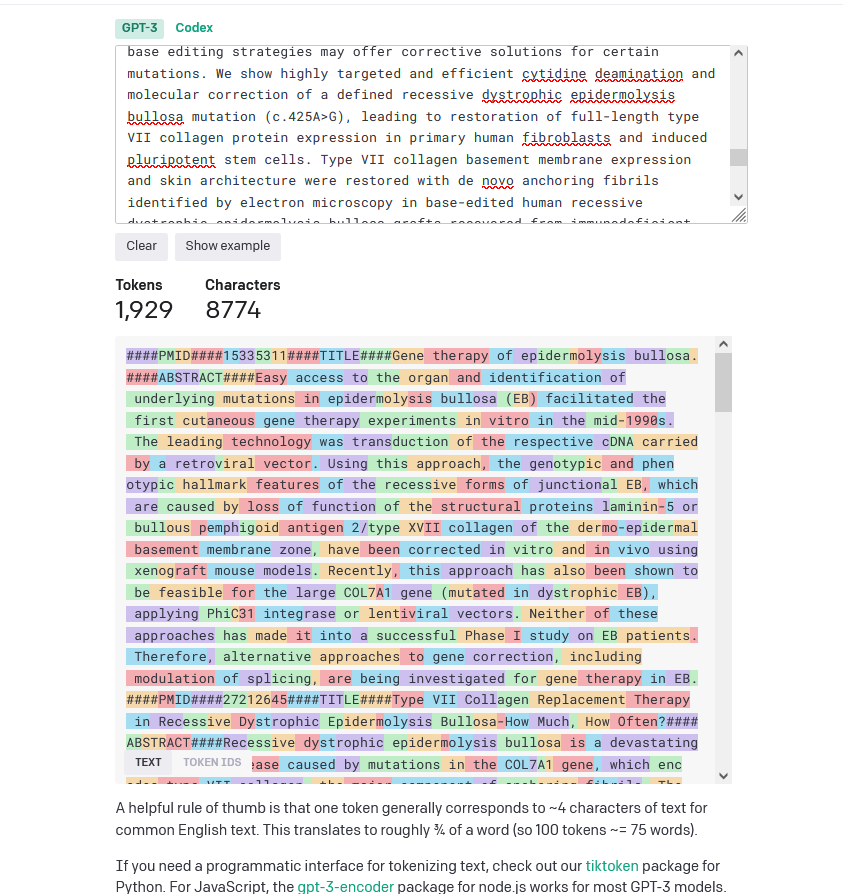

## Part 2: Access ChatGPT through the OpenAI API uaing the previously created in-context injection string

### I create some helper functions to work with and update prmpts easily

### This is the AI/LLM and  'Prompt Engineering' part of the project. I used ChatGPT and the API playgorund to refine the prompt to save token charges.

### Here I create a prompt using a Persona pattern, 'act as a medical writer', template pattern and question refinement, etc . . . to ensure we generate the output we are looking for.

### By providing the in-context learning or ground truth information for this prompt to use, it should generate a nice summary with a bit of value added information to help us with our exploratory search, without hallucinations, and ensuring synchronicity with the most current literature. This represents a productivity gain.

In [13]:
# The OpenAI ChatGPT API requires an account and an API key which you can 
# obtain at https://platform.openai.com/docs/quickstart/build-your-application
# It's a bit tricky to find, but about 1/2 through the 'Build your application'
# part of the tutorial, there is an "Add your API Key" section. 
# Here we'll grab the OpenAI API key from our .env file 

searchDate = """6/16/2023""" # change this, should not be hard coded here.
openai.api_key = config["OPENAI_API_KEY"]

# Helper function to access the ChatGPT API ChatCompletion call

def get_completion(prompt, model="gpt-3.5-turbo"): # Andrew mentioned that the prompt/ completion paradigm is preferable for this class
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

# another helper function we can use to look at token numbers

def get_completion_with_tokens(prompt, model="gpt-3.5-turbo"): # Andrew mentioned that the prompt/ completion paradigm is preferable for this class
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"], response.usage["completion_tokens"], response.usage["prompt_tokens"]


In [14]:
# Our prompt to anazlyze, summarize,, etc. using the context injection string generatted from the PubMed search is
# defined here. The helper function creates the prompt (also needed to 'refresh' the varaibles used within the prompt
# for subsequent calls.
# note of the in-context learning string is 'fed' in the prompt dynamically:  My Abstracts: ```{promptAbstracts}```

def getPrompt(promptKeywords,promptSearchDate,promptAbstracts):
    
    prompt = f"""
    Please act as a medical writer with deep experience of the biopharmaceutical industry and therapeutic agent development. 
    I have conducted a literature search on Pubmed. I will provide you my search terms, the date of my search 
    and with a list of abstracts that I retrieved in the following form: 

    ####PMID####1####TITLE####1####ABSTRACT####1####.####PMID####2####TITLE####2####ABSTRACT####2####...####PMID####N####TITLE####N####ABSTRACT####N####. 

    Your tasks are to: 

    1. Read the abstracts and then provide a single paragraph summary for the entire set of abstracts. 
    2. From the list of abstracts, identify 2-3 abstracts that best represent your summary and provide them to me in a bullet list of Title with PMIDs.  You must provide a maximum of only 3 abstracts.
    3. From your reading of all the abstracts, create 3 questions for me that I can use to demonstrate that I have understood the essential and most relevant concepts. 
    4. Finally, suggest an alternative set of search terms I could use on Pubmed to help me better refine my search. 

    Format your report to me as such:

    PubMed Literature Search Conducted On: <date provided>

    Keywords: ####keywords I used####

    Summary: ####your 1 paragraph summary####

    References: ####your list of references with PMID followed by Title####

    Questions: ####Your list of questions to test my knowledge####

    Refined Search Terms: ####list of better and/or alternatives search terms###

    Please use the following values below delimited by triple backticks to complete you tasks.
 
    My Keywords : ```{promptKeywords}```
    Date of Search: ```{promptSearchDate}```
    My Abstracts: ```{promptAbstracts}```
    """

    return prompt

prompt = getPrompt(keywords, searchDate, abstracts)
response = get_completion(prompt)
print(response)

PubMed Literature Search Conducted On: 6/16/2023

Keywords: dystrophic epidermolysis bullosa gene therapy clinical trials

Summary: Gene therapy is a promising approach for the treatment of dystrophic epidermolysis bullosa (DEB). Advances in gene delivery have led to the development of safe and effective gene therapies for junctional and dystrophic epidermolysis bullosa. Beremagene geperpavec (B-VEC) is a topical investigational herpes simplex virus type 1 (HSV-1)-based gene therapy designed to restore type VII collagen (C7) protein by delivering COL7A1. B-VEC has been shown to promote wound healing in patients with RDEB. Controlled clinical investigations assessing the effects of cannabinoid-based medicines (CBMs) on pain in EB patients are lacking. The C4EB study is an explorative randomized, placebo-controlled, and double-blind intervention crossover study that aims to assess the effects of CBMs on pain in EB patients.

References:
- PMID: 31068252, TITLE: Gene Therapy for Epidermol

In [ ]:
prompt = getPrompt(keywords, searchDate, abstracts)    
response = get_completion(prompt)
print(response)

## Let's try the suggested refined search terms

In [15]:
# perform the PubMed search with the new keywords
keywords = "dystrophic epidermolysis bullosa gene therapy clinical trials COL7AI"

pmidList = getPMIDs(emailAddr,maxResults,keywords)
citations = getCitations(pmidList)
abstracts = getContextInjection(citations)

num_tokens = len(encoding.encode(abstracts))
print(num_tokens)

1976


In [16]:
prompt = getPrompt(keywords, searchDate, abstracts)    
response = get_completion(prompt)
print(response)

PubMed Literature Search Conducted On: 6/16/2023

Keywords: dystrophic epidermolysis bullosa gene therapy clinical trials COL7AI

Summary: Gene therapy is a promising approach for the treatment of dystrophic epidermolysis bullosa (DEB), a rare genetic blistering skin disease caused by mutations in COL7A1. Advances in gene delivery have led to the development of safe and effective gene therapies for DEB, including beremagene geperpavec (B-VEC), an engineered, non-replicating COL7A1 containing herpes simplex virus type 1 (HSV-1) vector. Clinical trials have shown that B-VEC is an easily administered, safely tolerated, topical molecular corrective therapy promoting wound healing in patients with RDEB. Additionally, the use of cannabinoid-based medicines (CBMs) has shown promise in reducing the burden of symptoms in EB patients. 

References: 
- PMID: 35347281 Title: In vivo topical gene therapy for recessive dystrophic epidermolysis bullosa: a phase 1 and 2 trial.
- PMID: 36516090 Title: 